In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import scikit_posthocs as sp
from scipy.stats import binom, poisson, norm
from scipy.stats import kruskal

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

In [2]:
# Read in the data
# f = open('data/Dairy_unmerged.xlsx', 'rb').read()
# dairy_df = pd.read_excel(f)

FAO_dairy_total_df = pd.read_csv("data/FAOSTAT_data_en_4-28-2024.csv")

In [3]:
# Check the data

FAO_dairy_total_df.shape
FAO_dairy_total_df.head()

(6736, 15)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2004,2004,t,32937.0,A,Official figure,NaN
1,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2005,2005,t,31208.0,A,Official figure,NaN
2,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2006,2006,t,33059.0,A,Official figure,NaN
3,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2007,2007,t,34667.0,A,Official figure,NaN
4,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2008,2008,t,33517.0,A,Official figure,NaN


In [4]:
# Check the data types for each column

FAO_dairy_total_df.Item.value_counts()
FAO_dairy_total_df.Element.value_counts()
FAO_dairy_total_df.Unit.value_counts()

Item
Raw milk of cattle                                 1026
Raw milk of goats                                   808
Raw milk of sheep                                   651
Butter of cow milk                                  464
Skim milk of cows                                   453
Cheese from whole cow milk                          450
Skim milk and whey powder                           407
Whole milk powder                                   389
Whole milk, evaporated                              379
Whole milk, condensed                               328
Cheese from milk of sheep, fresh or processed       286
Cheese from milk of goats, fresh or processed       257
Cheese from skimmed cow milk                        243
Buttermilk, dry                                     239
Raw milk of buffalo                                 212
Skim milk, condensed                                 64
Skim milk, evaporated                                49
Cheese from milk of buffalo, fresh or proce

Element
Production    5520
Yield         1216
Name: count, dtype: int64

Unit
t           5520
100 g/An    1216
Name: count, dtype: int64

In [5]:
# Filter the data from FAO to only include the total production and yield of raw milk of cattle and buffalo

FAO_dairy_total_df = FAO_dairy_total_df[(FAO_dairy_total_df.Item == 'Raw milk of cattle') | (FAO_dairy_total_df.Item == 'Raw milk of buffalo')].reset_index(drop=True)
FAO_dairy_total_df.head(100)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2018,2018,t,0.0,A,Official figure,NaN
1,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2019,2019,t,0.0,A,Official figure,NaN
2,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2020,2020,t,0.0,A,Official figure,NaN
3,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2021,2021,t,0.0,A,Official figure,NaN
4,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2022,2022,t,0.0,A,Official figure,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,QCL,Crops and livestock products,100,Bulgaria,5510,Production,2212.0,Raw milk of buffalo,2008,2008,t,7173.0,A,Official figure,NaN
96,QCL,Crops and livestock products,100,Bulgaria,5420,Yield,2212.0,Raw milk of buffalo,2009,2009,100 g/An,13222.0,A,Official figure,NaN
97,QCL,Crops and livestock products,100,Bulgaria,5510,Production,2212.0,Raw milk of buffalo,2009,2009,t,7022.0,A,Official figure,NaN
98,QCL,Crops and livestock products,100,Bulgaria,5420,Yield,2212.0,Raw milk of buffalo,2010,2010,100 g/An,15876.0,A,Official figure,NaN


In [6]:
# Create new dataframe selecting columns of interest from previous dataframe. Group data by Member State, Year and Element and Values for raw milk are summed for each group

dairy_output_df = FAO_dairy_total_df[[ 'Year', 'Area', 'Element', 'Value']].groupby(by=['Area', 'Year', 'Element']).sum().reset_index()
dairy_output_df.rename(columns={'Area': 'Member State'}, inplace=True)
dairy_output_df['Member State'].replace({'Netherlands (Kingdom of the)': 'Netherlands'}, inplace=True)

dairy_output_df.head()

,Member State,Year,Element,Value
0,Austria,2004,Production,3137322.0
1,Austria,2004,Yield,58019.0
2,Austria,2005,Production,3113658.0
3,Austria,2005,Yield,57828.0
4,Austria,2006,Production,3146657.0


In [7]:
dairy_output_df.dtypes

Member State     object
Year              int64
Element          object
Value           float64
dtype: object

In [8]:
# Pivot the data to create columns for 'Production' and 'Yield' from 'Element' and assign 'Value' in each column to respective rows
dairy_output_df_pivoted =  dairy_output_df.pivot(index=['Year', 'Member State'], columns='Element', values='Value').reset_index() # Create columns out of individual rows and assign 'Value' column
dairy_output_df_pivoted.rename(columns={'Production': 'Production_tonnes', 'Yield': 'Yield_100g_per_An'}, inplace=True)
dairy_output_df_pivoted.head()

# Convert Yield from 100g per animal to Kg per animal
dairy_output_df_pivoted.Yield_100g_per_An = dairy_output_df_pivoted.Yield_100g_per_An / 10 # Convert to kg per animal
dairy_output_df_pivoted.rename(columns={'Yield_100g_per_An': 'Yield_Kg_per_An'}, inplace=True)
dairy_output_df_pivoted.head()

# Derive number of animals from Production and Yield
dairy_output_df_pivoted['Derived_Animal_Number'] = round(dairy_output_df_pivoted['Production_tonnes'] / (dairy_output_df_pivoted['Yield_Kg_per_An'] / 1000)).astype('int') # Converting Yield_Kg_per_An into Tonnes & then deriving number of animals
dairy_output_df_pivoted.head()


Element,Year,Member State,Production_tonnes,Yield_100g_per_An
0,2004,Austria,3137322.0,58019.0
1,2004,Belgium,3060000.0,56387.0
2,2004,Bulgaria,1350979.0,50878.0
3,2004,Croatia,684379.0,28749.0
4,2004,Cyprus,151220.0,73000.0


Element,Year,Member State,Production_tonnes,Yield_Kg_per_An
0,2004,Austria,3137322.0,5801.9
1,2004,Belgium,3060000.0,5638.7
2,2004,Bulgaria,1350979.0,5087.8
3,2004,Croatia,684379.0,2874.9
4,2004,Cyprus,151220.0,7300.0


Element,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number
0,2004,Austria,3137322.0,5801.9,540740
1,2004,Belgium,3060000.0,5638.7,542678
2,2004,Bulgaria,1350979.0,5087.8,265533
3,2004,Croatia,684379.0,2874.9,238053
4,2004,Cyprus,151220.0,7300.0,20715


In [9]:
# Calculate the median of Production, Yield and Derived Animal Number for each Member State over time period and split into percentiles

median_df = pd.DataFrame(dairy_output_df_pivoted['Member State'].unique().tolist(), columns=['Member State'])

def calc_median(df, column_name):
  df = df[['Member State', column_name]]
  return df.groupby(by=['Member State'], as_index=False).median()

for column_name in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    median_df = median_df.merge(calc_median(dairy_output_df_pivoted, column_name).rename(columns={column_name: column_name + '_median'}), on=['Member State'])
    median_df[column_name + '_percentiles'] =  pd.qcut(median_df[column_name + '_median'] , np.linspace(0,1,6), labels=range(1, 6, 1))


median_df.head()

,Member State,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
0,Austria,3393057.0,4,6459.8,2,532867.0,4
1,Belgium,3474000.0,4,7107.5,3,523284.0,4
2,Bulgaria,1101115.0,2,5025.6,1,210604.0,2
3,Croatia,711400.0,1,4319.3,1,176399.0,2
4,Cyprus,162373.0,1,7502.6,4,20715.0,1


Merging median volumns and percentiles into dataframe

In [10]:
dairy_output_df_pivoted = dairy_output_df_pivoted.merge(median_df, on=['Member State'])
dairy_output_df_pivoted.head()

,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
0,2004,Austria,3137322.0,5801.9,540740,3393057.0,4,6459.8,2,532867.0,4
1,2005,Austria,3113658.0,5782.8,538434,3393057.0,4,6459.8,2,532867.0,4
2,2006,Austria,3146657.0,5903.3,533034,3393057.0,4,6459.8,2,532867.0,4
3,2007,Austria,3155068.0,5997.4,526073,3393057.0,4,6459.8,2,532867.0,4
4,2008,Austria,3195948.0,6059.4,527436,3393057.0,4,6459.8,2,532867.0,4


### Plotting & Assessing Dairy production across EU member states over time

In [11]:
# import dash library

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.tools as tls

In [12]:
# Create a Dash app to visualise Dairy output for european member states over time

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number'],
            value="Production_tonnes",
        ),
        dcc.Checklist(
            options=[
                {"label": "80-100%", "value": 5},
                {"label": "60-80%", "value": 4},
                {"label": "40-60%", "value": 3},
                {"label": "20-40%", "value": 2},
                {"label": "0-20%", "value": 1},
            ],
            value=[4, 5],
            id="percentiles",
            inline=True,
        ),
    ],  style={'width': '30%', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Checklist(
                id="states",
                options=dairy_output_df_pivoted['Member State'].unique(),
                value=dairy_output_df_pivoted['Member State'].unique(),
            ),
        ], style={'width': '8%', 'float': 'left', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Graph(id="line-graph"),
    ],  style={'width': '92%', 'float': 'right', 'display': 'inline-block'}),
], style={"backgroundColor": "white"})


@app.callback(
    Output("line-graph", "figure"), 
    Input("metric", "value"),
    Input("states", "value"),
    Input('percentiles', 'value'),
)
def update_line_chart(metric, states, percentiles):
    data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(states) & (dairy_output_df_pivoted[metric + '_percentiles'].isin(percentiles))]
    fig = px.line(data, x="Year", y=metric, color='Member State', title=f"Dairy {metric}")
    return fig


app.run_server(debug=True)

Validation of yield ranking of ireland within EU countries, https://www.irishexaminer.com/farming/arid-41257186.html (Find more legitimate source)

Does Irish Milk production differ significantly from that of a closely comparable country for output such as Lithuania for yield, and Denmark for Production output. 

Efficiency or Expansion? https://www.dlg.org/en/agriculture/topics/dlg-agrifuture-magazine/knowledge-skills/danish-milk-producers-efficiency-is-the-secret-of-their-success

Correlation of Variables in  ALL European member states

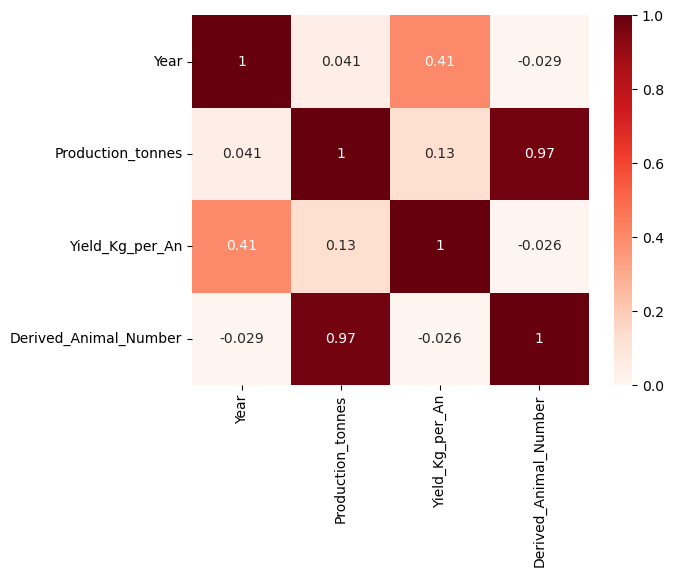

In [13]:
# Assessing the correlation of the different quantitative variables in the dataset of European milk production. Correlation matrix shows a moderate positive correlation between Year and Yield along with a negative correlation with Animal Numbers. 
# This indicates a progression to overall more efficient Dairy production in Europe.

corr = dairy_output_df_pivoted[['Year', 'Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']].dropna().corr()
sns.heatmap(corr, cmap="Reds", annot=True, vmin=0, vmax=1);

Correlation of Dairy variables in Ireland, Lithuania, Latvia & Denmark

<Axes: >

<Axes: >

<Axes: >

<Axes: >

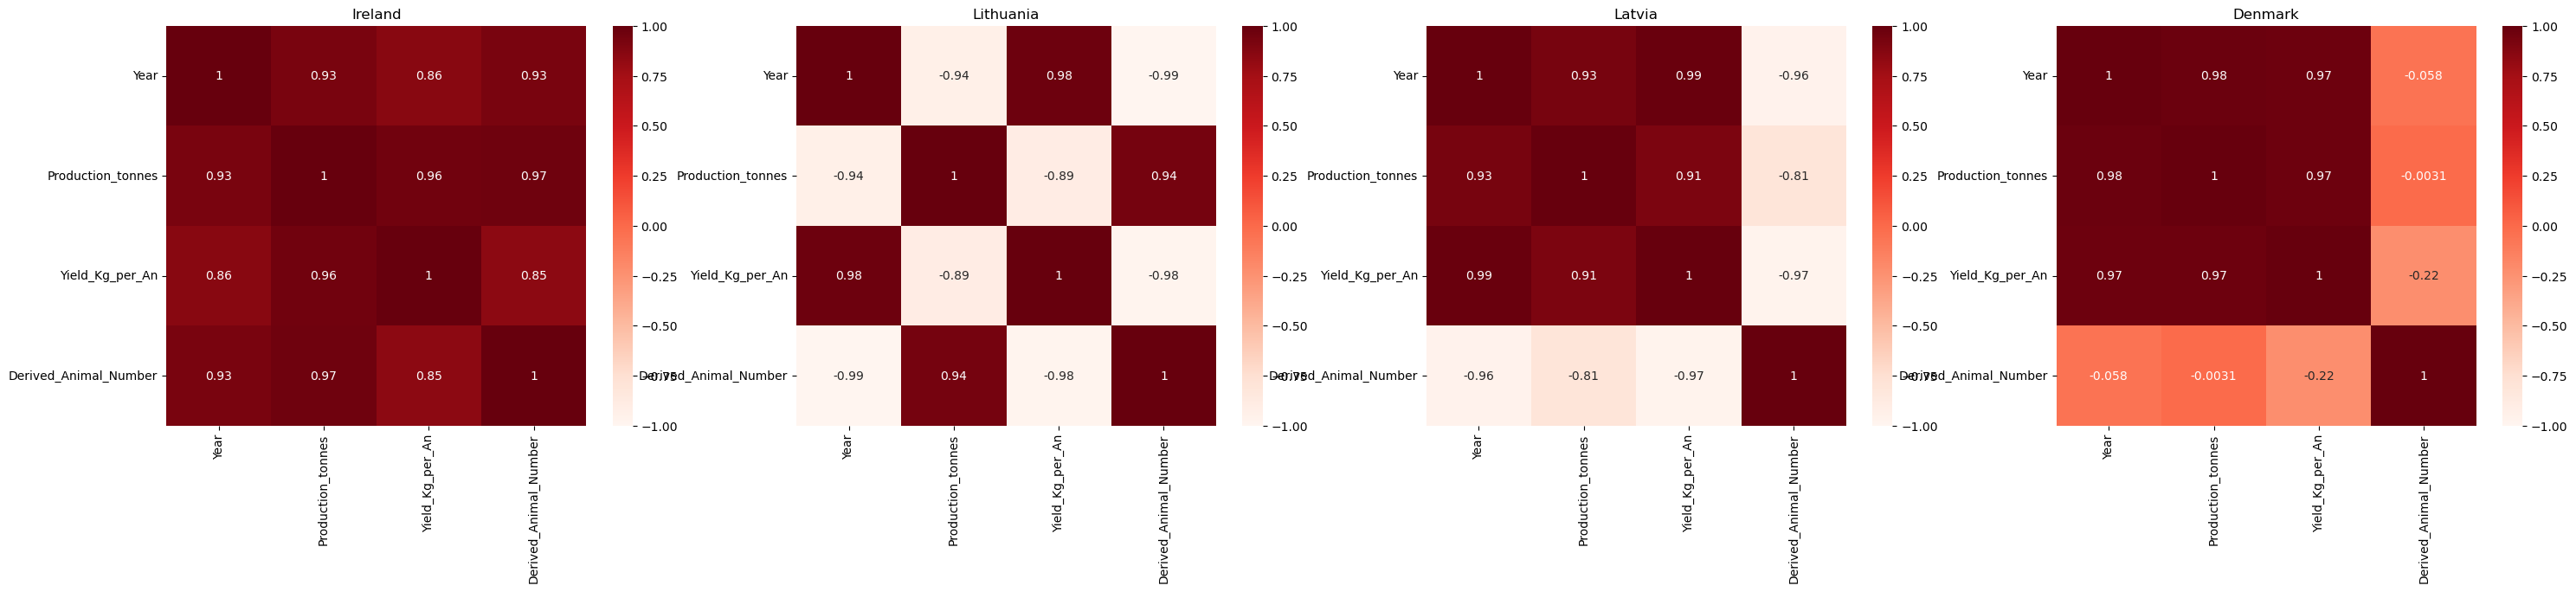

In [14]:
# Assessing the correlation of the different quantitative variables in the dataset of IRISH milk production. 
# Correlation matrix shows a strong positive correlation between all variables, demonstrating an increase in the animal number and milk production over time. 
# Yield exhibited the weakest positive correlation with time compared to all other variable indicating that the observed increase in output is more due to increased animal number than increased yield,

# Assessing the correlation of the different quantitative variables in the dataset of Lithuanian milk production. 
# Correlation matrix shows a strong positive correlation between yield and year. Demonstrating an increase in milk yield per animal over time. 
# Animal number and milk production exhibit a strong negative correlation with year indicating a decline in lithuanian milk production and scale over time.

# Assessing the correlation of the different quantitative variables in the dataset of Latvian milk production. 
# Correlation matrix shows a strong positive correlation between yield, production and year, demonstrating an increase in milk production and yield over time. 
# Yield exhibited the strongest correlation with time compared to all other variable indicating that the observed increase in milk production is largely due to increased yield per animal, with overall animal number showing a strong negative correlation with time.

# Assessing the correlation of the different quantitative variables in the dataset of Danish milk production. 
# Correlation matrix shows a strong positive correlation between yield, production and year, demonstrating an increase in milk production and yield over time. 
# Yield and production both exhibited the strong positive correlation with time indicating that the observed increase in milk production is due to largely due to increased yield per animal, with overall animal number showing a strong negative correlation with time.


countries_to_assess = ['Ireland', 'Lithuania','Latvia', 'Denmark']

fig, axes = plt.subplots(1, len(countries_to_assess), figsize=(9 * len(countries_to_assess), 6))

for i, state in enumerate(countries_to_assess):
    corr = dairy_output_df_pivoted.loc[dairy_output_df_pivoted['Member State'] == state, ['Year', 'Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']].dropna().corr()
    sns.heatmap(corr, cmap="Reds", annot=True, vmin=-1, vmax=1, ax=axes[i])
    _ = axes[i].set_title(state);

# Heatmap color scale limits to allow for direct comparison of correlation of variables for different countries without adjustment for correlation values obtained.


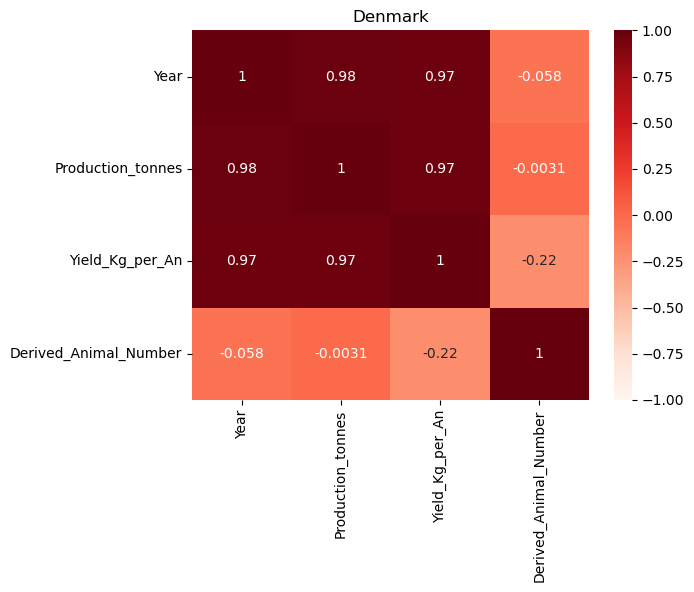

In [15]:
# fig, axes = plt.subplots(1, len(countries_to_assess), figsize=(9 * len(countries_to_assess), 6))

country = 'Denmark'

corr = dairy_output_df_pivoted.loc[dairy_output_df_pivoted['Member State'] == country, ['Year', 'Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']].dropna().corr()
a = sns.heatmap(corr, cmap="Reds", annot=True, vmin=-1, vmax=1)
a.set_title(country);


## Statistics

In [16]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats import weightstats

#Importing the libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

from statsmodels.tsa.stattools import adfuller

### Visualising distribution of variables from all european member states

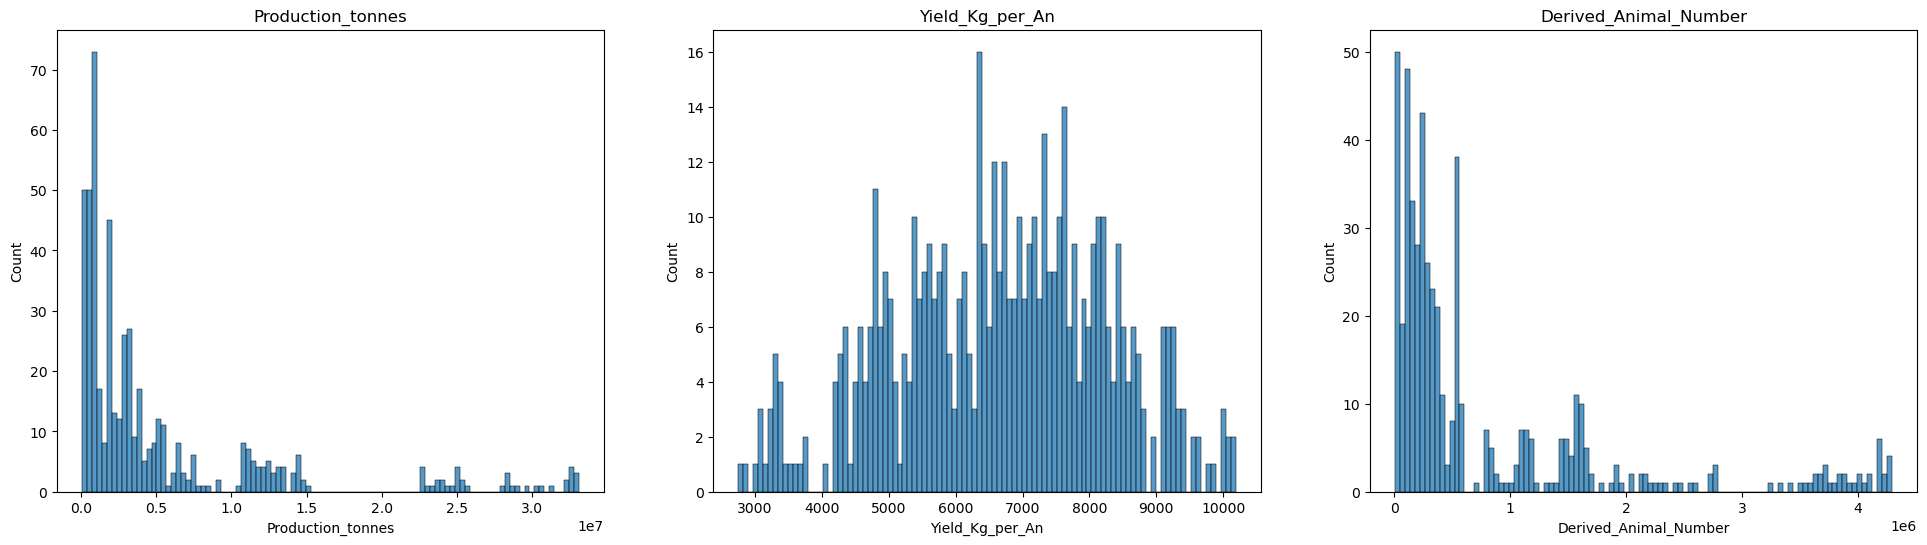

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
    _ = sns.histplot(data=dairy_output_df_pivoted, x=column, bins=100, ax=axes[i])
    _ = axes[i].set_title(column)


## Condition 1- Normality of Distribution
## Asssessing normality of distribution of variables from all european member states (Alpha:0.05)

In [18]:
for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
    k2, p = stats.normaltest(dairy_output_df_pivoted[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

# Normality test shows variables are not normally distributed for all aggregated EU member states

Production_tonnes
p = 2.68534e-52
The null hypothesis (H0) can be rejected 

Yield_Kg_per_An
p = 0.00342301
The null hypothesis (H0) can be rejected 

Derived_Animal_Number
p = 1.61122e-43
The null hypothesis (H0) can be rejected 



### QQ plots visualises the normality of distribution of all variables across all EU member states. 

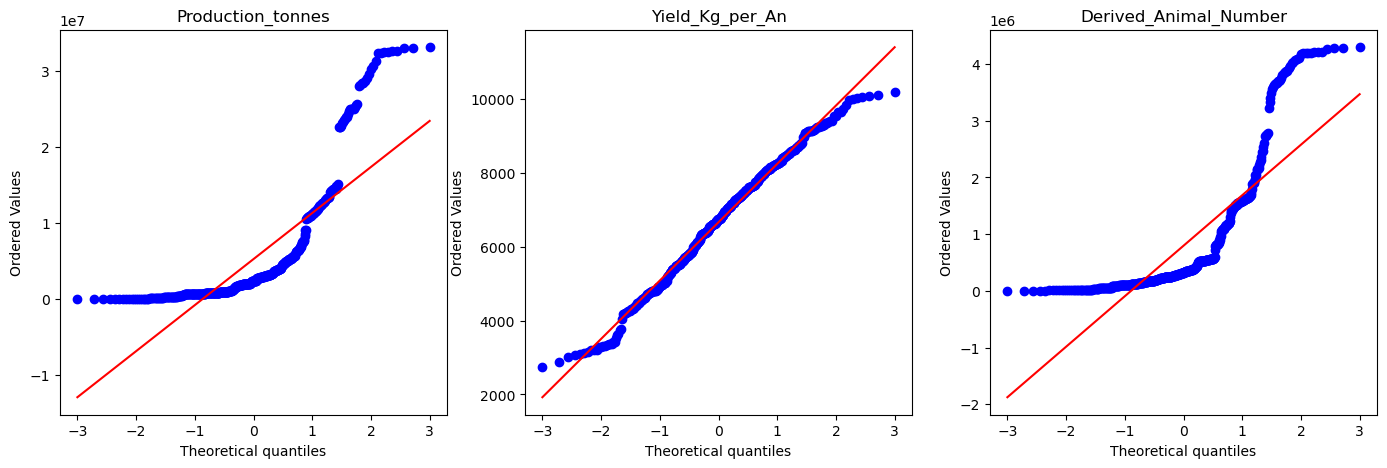

In [19]:
# Check normality of the data for Production & Yield & Number of animals
# Probability plot - QQ plot
# https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
   _ = stats.probplot(dairy_output_df_pivoted[column], plot=axes[i]);
   _ = axes[i].set_title(column);
f.show()

# QQ plot visualises the distribution for all EU member states with a deviation from the normal distribution line, indicating a non normal distribution. 
# Yield exhibit a more linear relationship with the normal distribution line than Production and Animal number indicating it is the variable which is closest to normally distributed for aggregated EU member states.

### QQ plot visual assessment of the normality of distribution of all variables in selected european member states (Ireland, Denmark, Latvia, Lithuania). 

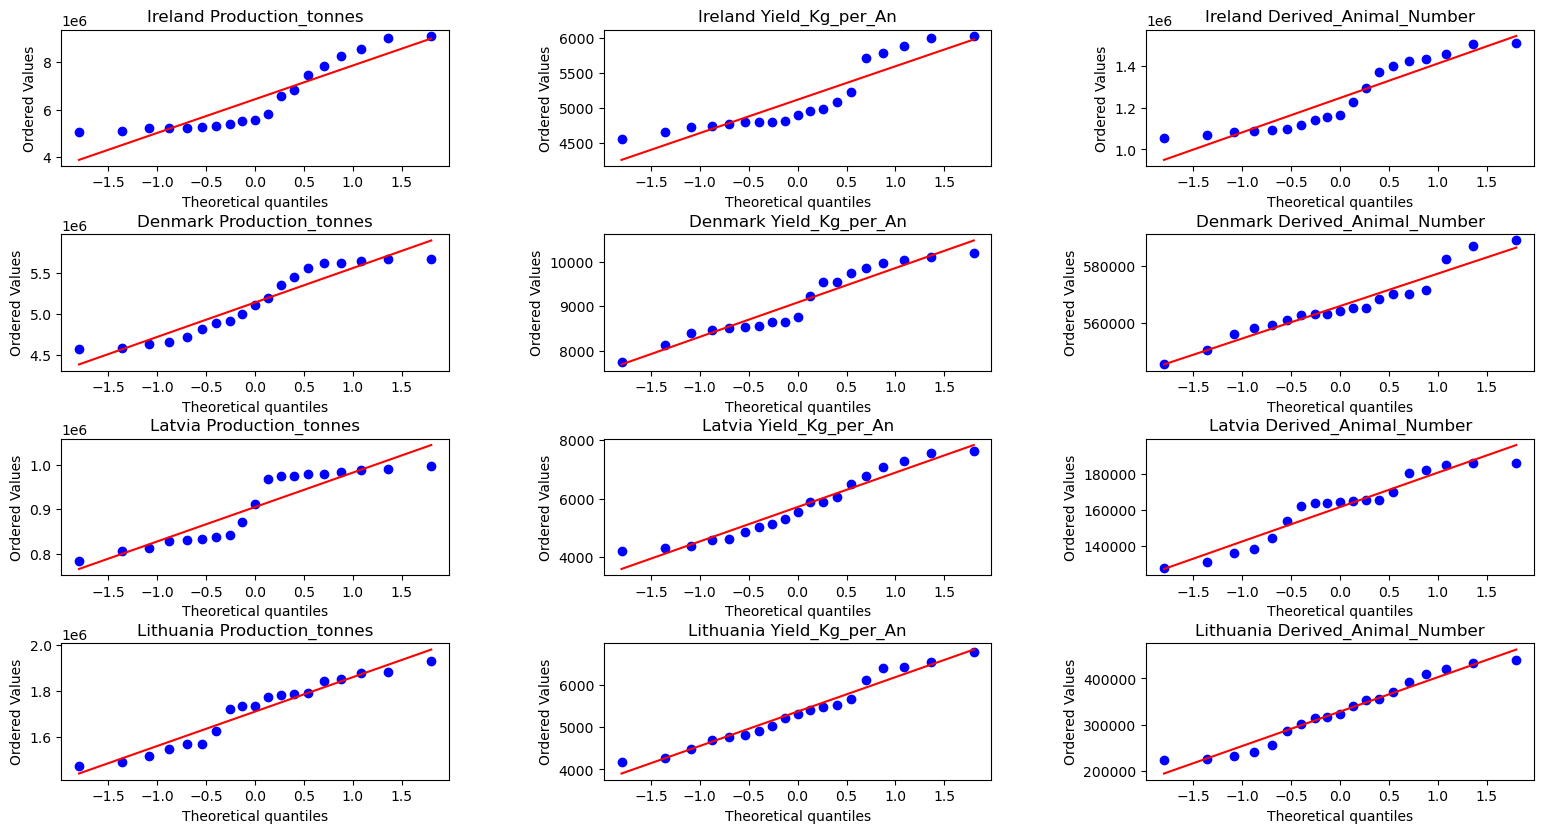

In [87]:
f, axes = plt.subplots(4, 3, figsize=(19, 10))

for i, state in enumerate(['Ireland', 'Denmark', 'Latvia', 'Lithuania']): 
    state_data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'] == state]
    for j, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
       _ = stats.probplot(state_data[column], plot=axes[i, j]);
       _ = axes[i, j].set_title(state + ' ' + column,), ;

plt.subplots_adjust(top = 0.8, bottom=0.05, hspace=0.5, wspace=0.4)
f.show()

# QQ plot visualises the non normal distribution for selected EU member states

*** Both Shapiro-Wilk and D'Agostino's K^2 normality tests are tested on all variables for all member states. 


In [89]:
normality_test_results = []

for state in dairy_output_df_pivoted['Member State'].unique(): 
    state_data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'] == state]
    for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
        shap_result = stats.shapiro(state_data[column]);
        k2, norm_result_pvalue = stats.normaltest(state_data[column])
        normality_test_results.append([state, column, shap_result.pvalue >= 0.05, shap_result.statistic, shap_result.pvalue, norm_result_pvalue >= 0.05, k2, norm_result_pvalue])

normality_test_results_df = pd.DataFrame(data=normality_test_results, columns=['Member State', 'Metric', 'shap_Normally_Distributed', 'shap_Statistic', 'shap_p-value', 'dag_Normally_Distributed', 'norm_k2', 'norm_p-value'])

In [92]:
# Print table for Ireland, Lithuania, Latvia, Denmark
normality_test_results_df[normality_test_results_df['Member State'].isin(['Ireland', 'Denmark', 'Latvia', 'Lithuania'])]

,Member State,Metric,shap_Normally_Distributed,shap_Statistic,shap_p-value,dag_Normally_Distributed,norm_k2,norm_p-value
18,Denmark,Production_tonnes,False,0.880699,0.022081,False,9.675400,0.007925
19,Denmark,Yield_Kg_per_An,True,0.912691,0.082956,True,4.640328,0.098257
20,Denmark,Derived_Animal_Number,True,0.942100,0.287589,True,1.707435,0.425829
39,Ireland,Production_tonnes,False,0.820394,0.002296,True,3.875891,0.143999
40,Ireland,Yield_Kg_per_An,False,0.816618,0.002013,True,3.741031,0.154044
41,Ireland,Derived_Animal_Number,False,0.861015,0.010189,False,8.103802,0.017389
45,Latvia,Production_tonnes,False,0.828717,0.003081,False,16.701409,0.000236
46,Latvia,Yield_Kg_per_An,True,0.927430,0.155277,True,3.236293,0.198266
47,Latvia,Derived_Animal_Number,True,0.914181,0.088368,True,1.500379,0.472277
48,Lithuania,Production_tonnes,True,0.925705,0.144287,True,3.780271,0.151051


In [93]:
@interact
def show_normality_test_results(metric=['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number'], is_shap_normally_distr=True, condition=['either (or)', 'both (and)'], is_dag_normally_distr=True):
    if condition == 'either (or)':
        res = normality_test_results_df[(normality_test_results_df['Metric'] == metric) & ((normality_test_results_df['shap_Normally_Distributed'] == is_shap_normally_distr) | (normality_test_results_df['dag_Normally_Distributed'] == is_dag_normally_distr))]
    else:
        res = normality_test_results_df[(normality_test_results_df['Metric'] == metric) & (normality_test_results_df['shap_Normally_Distributed'] == is_shap_normally_distr) & (normality_test_results_df['dag_Normally_Distributed'] == is_dag_normally_distr)]
    print('Size of the filtered DF: ', res.shape)
    return res

interactive(children=(Dropdown(description='metric', options=('Production_tonnes', 'Yield_Kg_per_An', 'Derived…

### For Ireland only Yield cannot reject the null hypothesis and is therefore the only variable which is normally distributed by the D'Agostino normality tests but not by Shapiro-Wilks. In comparison Denmark, Latvia and Lithuania have normal distribution by both normality tests for Yield And Number of Animal. However only Lithuania exhibited normal distribution for all variables by both tests.

### Therefore parametric tests will be used for Yield and non-parametric tests for Production and Number of Animals.

In [26]:
def select_data_by_parameters(df, state, year_start, year_end=0):
    if year_end == 0:
        year_end = max(df.Year)
    return df[(df['Member State'] == state) & (df.Year >= year_start) & (df.Year <= year_end)]


def null_hypothesis_test(test_result, alpha=0.05):
    if test_result.pvalue < alpha:  # null hypothesis: countries are the same in terms of dairy output
        print("The null hypothesis (H0) can be rejected")
    else:
        print("The null hypothesis (H0) cannot be rejected")


In [94]:
# Levene test on Milk Yield
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Yield_Kg_per_An]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=4.6556588831997825, pvalue=0.0049673307086175586)

BartlettResult(statistic=11.457806526234972, pvalue=0.009491239607007491)

## Breaking down data for dairy industry before and after the abolition of european milk quotas

## Assessing normality of distribution of variables from individual european member states

In [28]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.143999
The null hypothesis (H0) cannot be rejected 

Yield_Kg_per_An
p = 0.154044
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.0173893
The null hypothesis (H0) can be rejected 



In [29]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.00792526
The null hypothesis (H0) can be rejected 

Yield_Kg_per_An
p = 0.0982575
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.425829
The null hypothesis (H0) cannot be rejected 



In [30]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.143999
The null hypothesis (H0) cannot be rejected 

Yield_Kg_per_An
p = 0.154044
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.0173893
The null hypothesis (H0) can be rejected 



### Normality test indicates that Yield is the only variable which is normally distributed in both Ireland and Denmark.

## Comparison of Ireland and Denmark by PRODUCTION by Wilcoxon signed-rank test- throughout, before and after the abolition of european milk quotas in 2015

In [31]:
# Dairy production Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater')
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=190.0, pvalue=1.9073486328125e-06)

The null hypothesis (H0) can be rejected


In [32]:
# Dairy production Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater')
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=78.0, pvalue=0.000244140625)

The null hypothesis (H0) can be rejected


In [33]:
# Dairy production Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater', )
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=28.0, pvalue=0.0078125)

The null hypothesis (H0) can be rejected


## Comparison of PRODUCTION by T-Test before and after the abolition of european milk quotas in 2015 for Ireland and Denmark as t.test can accept different number of samples in both groups

## Condition #2 - Equality of Variance
### Levene's Test assessment of homogeneity of variance for a variable across multiple groups. If the Levene test pvalue is <0.05, the variances in the groups are different and the assumptions for ANOVA are not met.
Definition based on the median is recommended as the choice that provides good robustness against many types of non-normal data while retaining good power. 
The median is used as the center because it provides a more robust test. An alpha value of 0.05 was to be more stringent for declaring heterogeneity of variance between groups. Based on decision rules, we can reject the Null Hypothesis and state that that Yield, Production and Animal number are heterogenous in variance.
Since the data does not satisfy the criteria of normal distribution or equality of variance, the non parametric tests, Welch's ANOVA and Kruskal-Wallis H Test are used instead of ANOVA.


In [95]:
# Levene test on Milk Yield
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Yield_Kg_per_An]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=4.6556588831997825, pvalue=0.0049673307086175586)

BartlettResult(statistic=11.457806526234972, pvalue=0.009491239607007491)

In [96]:
# Levene test on Milk production
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Production_tonnes]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=12.727836884597934, pvalue=9.192166733825764e-07)

BartlettResult(statistic=136.58284046916296, pvalue=2.06156328728102e-29)

In [97]:
# Levene test on Milk production
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Derived_Animal_Number]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=19.56372916759224, pvalue=2.2252883685971164e-09)

BartlettResult(statistic=116.55398032092354, pvalue=4.260962200365734e-25)

## The parametric Welch’s ANOVA is used as an alternative to the standard one-way ANOVA when assumption of equal variance is violated. To see if there is a statistically significant difference in the means of three or more independent groups.

In [98]:
anova_grouped_df = (select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An.tolist() + 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An.tolist() + 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Yield_Kg_per_An.tolist() +
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Yield_Kg_per_An.tolist())

num_repeats = len(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An.tolist())

# create DataFrame 
df = pd.DataFrame({'yield': anova_grouped_df, 
                   'group': np.repeat(['Ireland', 'Denmark', 'Latvia', 'Lithuania'], 
                                      repeats=num_repeats)}) 
  
# perform Welch's ANOVA 
pg.welch_anova(dv='yield', between='group', data=df) 

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,38.505821,124.493373,7.323411e-20,0.799996


In [99]:
dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Latvia', 'Lithuania'])]

,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
114,2004,Denmark,4569000.0,7757.2,589001,5104720.0,4,8765.9,5,564268.0,4
115,2005,Denmark,4584000.0,8123.8,564268,5104720.0,4,8765.9,5,564268.0,4
116,2006,Denmark,4627000.0,8408.5,550277,5104720.0,4,8765.9,5,564268.0,4
117,2007,Denmark,4650000.0,8525.5,545423,5104720.0,4,8765.9,5,564268.0,4
118,2008,Denmark,4720000.0,8459.1,557979,5104720.0,4,8765.9,5,564268.0,4
...,...,...,...,...,...,...,...,...,...,...,...
318,2018,Lithuania,1568010.0,6120.3,256198,1734726.0,2,5315.4,1,323497.0,3
319,2019,Lithuania,1547430.0,6423.5,240901,1734726.0,2,5315.4,1,323497.0,3
320,2020,Lithuania,1488000.0,6389.0,232900,1734726.0,2,5315.4,1,323497.0,3
321,2021,Lithuania,1473280.0,6542.1,225200,1734726.0,2,5315.4,1,323497.0,3


In [100]:
pg.pairwise_gameshowell(data=dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Latvia', 'Lithuania'])], dv='Yield_Kg_per_An' ,between='Member State').round(3)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Denmark,Ireland,9082.853,5115.700,3967.153,208.221,19.053,31.089,0.000,6.052
1,Denmark,Latvia,9082.853,5714.179,3368.674,313.763,10.736,31.362,0.000,3.410
2,Denmark,Lithuania,9082.853,5369.368,3713.484,250.199,14.842,35.963,0.000,4.714
3,Ireland,Latvia,5115.700,5714.179,-598.479,284.983,-2.100,24.655,0.181,-0.667
4,Ireland,Lithuania,5115.700,5369.368,-253.668,212.996,-1.191,30.510,0.637,-0.378
5,Latvia,Lithuania,5714.179,5369.368,344.811,316.953,1.088,31.934,0.699,0.346


### Games-Howell test identified that Yield is significantly different between Denmark and the three other selected states for yield

## Statistics - Comparison of Ireland and other member states by selected using non-parametric  Kruskall wallis and Dunn tests

### Kruskal wallis test demonstrates there are significant difference between Ireland, Denmark, Latvia, and Lithuania for Milk Yield.

In [ ]:
kruskal_yield_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Yield_Kg_per_An]
kruskal_test = kruskal(*kruskal_yield_dfs)
kruskal_test

KruskalResult(statistic=43.6015037593985, pvalue=1.8339312563270992e-09)

### Post-Hoc Dunn test identifies that Ireland is not significantly different from Latvia or Lithuania for Milk yield, However milk yield is significantly different in Denmark compared to all other selected member states.

In [ ]:
p_values = sp.posthoc_dunn(kruskal_yield_dfs, p_adjust='holm')
print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2         3             4
1  1.000000e+00  1.922066e-08  0.710791  1.000000e+00
2  1.922066e-08  1.000000e+00  0.000009  7.509006e-07
3  7.107908e-01  8.628252e-06  1.000000  1.000000e+00
4  1.000000e+00  7.509006e-07  1.000000  1.000000e+00
       1      2      3      4
1  False   True  False  False
2   True  False   True   True
3  False   True  False  False
4  False   True  False  False


### Kruskal wallis test demonstrates there are significant difference between Ireland, Denmark, Latvia, and Lithuania for Milk production.

In [111]:
dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Latvia', 'Lithuania'])

0      False
1      False
2      False
3      False
4      False
       ...  
508    False
509    False
510    False
511    False
512    False
Name: Member State, Length: 513, dtype: bool

In [112]:
kruskal_prod_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Production_tonnes]
kruskal_test = kruskal(*kruskal_prod_dfs)
kruskal_test

KruskalResult(statistic=65.55998848796634, pvalue=3.80686917655369e-14)

### Post-Hoc Dunn test identifies that Ireland is not significantly different from Denmark for Milk production, but is significantly different to Latvia and Lithuania.

In [109]:
p_values = sp.posthoc_dunn(kruskal_prod_dfs, p_adjust='holm')

print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2             3         4
1  1.000000e+00  1.320889e-01  2.092093e-08  0.003781
2  1.320889e-01  1.000000e+00  9.309641e-13  0.000009
3  2.092093e-08  9.309641e-13  1.000000e+00  0.016009
4  3.780997e-03  8.946457e-06  1.600900e-02  1.000000
       1      2      3      4
1  False  False   True   True
2  False  False   True   True
3   True   True  False   True
4   True   True   True  False


### Kruskal wallis test demonstrates there are significant difference between Ireland, Denmark, Latvia, and Lithuania for Number of Dairy Animals.

In [113]:
kruskal_anim_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Latvia', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Lithuania', 2004).Derived_Animal_Number]
kruskal_test = kruskal(*kruskal_anim_dfs)
kruskal_test

KruskalResult(statistic=70.32563671410412, pvalue=3.635195451677846e-15)

### Post-Hoc Dunn test identifies all selected member states have significantly different number of Dairy Animals from one another.

In [114]:
p_values = sp.posthoc_dunn(kruskal_anim_dfs, p_adjust='holm')

print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2             3             4
1  1.000000e+00  2.401221e-02  1.068778e-14  5.670945e-07
2  2.401221e-02  1.000000e+00  5.670945e-07  2.401221e-02
3  1.068778e-14  5.670945e-07  1.000000e+00  2.401221e-02
4  5.670945e-07  2.401221e-02  2.401221e-02  1.000000e+00
       1      2      3      4
1  False   True   True   True
2   True  False   True   True
3   True   True  False   True
4   True   True   True  False


### 2015 Abolition of Milk quotas: Parametric and non-Parametric tests to assess differences in Dairy production between Ireland and Denmark traversing the abolition of milk quotas in 2015.

In [ ]:
# Dairy production Ireland pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

prod_test = stats.ttest_ind(X1.Production_tonnes, X2.Production_tonnes, equal_var = False)
prod_test

null_hypothesis_test(prod_test)

TtestResult(statistic=8.079973959021997, pvalue=4.609733467121942e-05, df=7.82505260836455)

The null hypothesis (H0) can be rejected


In [ ]:
# Dairy production Denmark pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

prod_test = stats.ttest_ind(X1.Production_tonnes, X2.Production_tonnes, equal_var = False)
prod_test

null_hypothesis_test(prod_test)

TtestResult(statistic=9.314891158494039, pvalue=2.3275002413026226e-07, df=13.929751992501314)

The null hypothesis (H0) can be rejected


### Ireland has significantly greater overall dairy output compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in dairy production relative to the variation in the two sets demonstrates an increased seperation in the dairy production between the two countries following abolition (pre-abolition = 4.08 , postabolition = 8.12). Both countries exhibit a comparable t-statistic (Ireland = 8.08, Denmark = 9.31) for their increase in dairy production post abolition of quotas. 

## Comparison of Ireland and Denmark by ANIMAL NUMBER by Wilcoxon signed-rank test- throughout, before and after the abolition of european milk quotas in 2015

In [ ]:
# Animal number Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=17.862724730272557, pvalue=5.681957529124749e-13, df=18.164161455482553)

The null hypothesis (H0) can be rejected


In [ ]:
# Animal number Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=190.0, pvalue=1.9073486328125e-06)

The null hypothesis (H0) can be rejected


In [ ]:
# Animal number Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=27.515512816771057, pvalue=4.334815587210343e-12, df=11.828394493122202)

The null hypothesis (H0) can be rejected


In [ ]:
# Animal number Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=78.0, pvalue=0.000244140625)

The null hypothesis (H0) can be rejected


In [ ]:
# Animal number Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=44.01837454957842, pvalue=6.254875922602456e-09, df=6.1569760231509685)

The null hypothesis (H0) can be rejected


In [ ]:
# Animal number Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=28.0, pvalue=0.0078125)

The null hypothesis (H0) can be rejected


## Comparison of ANIMAL NUMBER by T.Test before and after the abolition of european milk quotas in 2015 for Ireland and Denmark as t.test can accept different number of samples in both groups

In [117]:
# Animal number Ireland pre and post EU quotas, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=10.951033629916553, pvalue=9.284300273086331e-09, df=15.70633871410474)

The null hypothesis (H0) can be rejected


In [118]:
# Animal number Denmark pre and post EU quotas t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=-0.3145195705742556, pvalue=0.7571293442666898, df=16.247364857711624)

The null hypothesis (H0) cannot be rejected


### Ireland has significantly greater number of dairy cows compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in dairy production relative to the variation in the two sets demonstrates an increased seperation in the animal number between the two countries following abolition (pre-abolition = 27.52 , postabolition = 44.02). Ireland exhibits a substantially larger t-statistic (Ireland = 10.95, Denmark = 0.31) for increase in animal post abolition of quotas. 

## Comparison of Ireland and Denmark by YIELD throughout, before and after the abolition of european milk quotas in 2015

In [ ]:
# Dairy yield per animal / efficiency, Ireland vs Denmark, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-19.052641741500345, pvalue=1.0555164166820542e-18, df=31.08889393828292)

The null hypothesis (H0) can be rejected


In [ ]:
# Dairy production Ireland vs Denmark pre Quota abolition, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-27.225127039542482, pvalue=6.162626267094616e-13, df=13.127470987009785)

The null hypothesis (H0) can be rejected


In [ ]:
# Dairy production Ireland vs Denmark post Quota abolition, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-23.502537939701934, pvalue=2.153412204196543e-09, df=9.007070481045954)

The null hypothesis (H0) can be rejected


## Comparison of YIELD before and after the abolition of european milk quotas in 2015 for Ireland and Denmark 

In [ ]:
# Dairy production Ireland pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=5.065684005647718, pvalue=0.0015823495438964461, df=6.805396556389755)

The null hypothesis (H0) can be rejected


In [ ]:
# Dairy production Denmark pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=8.424878670300462, pvalue=2.0947328444278717e-07, df=16.64885148707169)

The null hypothesis (H0) can be rejected


***T.test was used to compare Ireland and Denmark on milk yield as this variable is the only one which approximated normal distribution in both member states.
Ireland has significantly lower dairy yield compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in yield relative to the variation in the two sets demonstrates an increased  seperation in the yield between the two countries following abolition (pre-abolition = -27.23 , postabolition = -23.50), as Danish yield outperforms Ireland. 
Denmark has a larger t-statistic, indicating a greater increase in yield per animal post abolition of EU quotas compared to Ireland = 5.07, Denmark = 8.42). 

This indicates that while both countries demonstrate a comparable growth in overall production, Denmarksthe increased efficiency illustrated by the more substantial growth in yield per animal. Indicating that while Denmark improved its overall output to a similar degree to Ireland, it achieved this through improved yield per animal as compared to Ireland while increased its animal holdings. This is further demonstrate by the fact that Ireland has a significant increase in animal numbers following abolition of EU quotas which is not seen in Denmark, illustrating the different approaches of the two countries to increase dairy output. Through increased efficiency or scale of production.